Collab Version

## Load Data


In [1]:
# загрузка данных
!gdown --id 1WjL3nUWKnwrWw141iCLMB7L01r8KsofS

Downloading...
From: https://drive.google.com/uc?id=1WjL3nUWKnwrWw141iCLMB7L01r8KsofS
To: /content/ner_dataset.csv
100% 15.2M/15.2M [00:00<00:00, 26.9MB/s]


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [3]:
!pip install sklearn_crfsuite
!pip install eli5
!pip install transformers
!pip install seqeval
!pip install -U 'scikit-learn<0.24'
clear_output()

## EDA

In [4]:
# read data
df = pd.read_csv('ner_dataset.csv', encoding='Windows-1252')
df.fillna(method='ffill', axis=0, inplace=True)
df.shape

(1048575, 4)

In [5]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
%%time
# convert data to sentences
df_sentences = df.groupby(by=['Sentence #'])[['Word', 'POS', 'Tag']].agg(list)
sentences_ner = df_sentences.apply(lambda x: [(x['Word'][i], x['Tag'][i]) for i in range(len(x['Word']))], axis=1).values.tolist()

CPU times: user 15.3 s, sys: 237 ms, total: 15.5 s
Wall time: 15.5 s


In [7]:
# some statistics
text_length = len(df['Sentence #'].unique())
vocab_size = len(df['Word'].unique())
print(f"Text Length: {text_length}, Vocab Size: {vocab_size}")

Text Length: 47959, Vocab Size: 35178


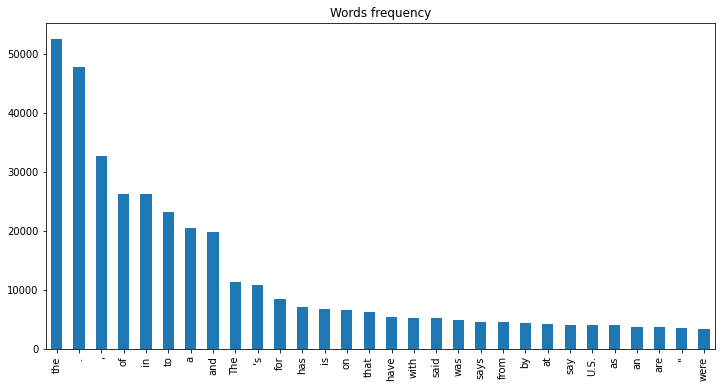

In [8]:
# word frequency
plt.figure(figsize=(12, 6))
df['Word'].value_counts()[:30].plot(kind='bar')
plt.title('Words frequency')
plt.show()

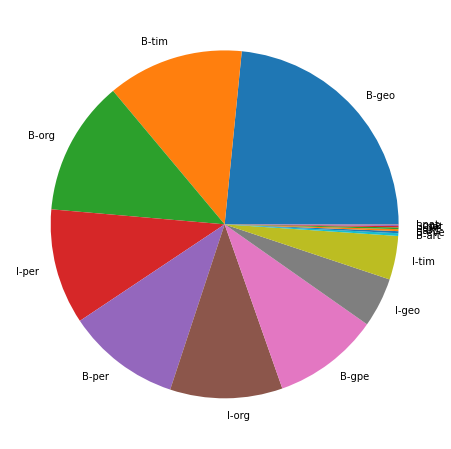

In [9]:
# TAG distribution
plt.figure(figsize=(12, 8))
plt.pie(x=df['Tag'].value_counts().drop('O').values, labels=df['Tag'].value_counts().drop('O').index)
plt.show()

In [10]:
# train test split
np.random.shuffle(sentences_ner)
# NER
train_data_ner = sentences_ner[:40000]
val_data_ner = sentences_ner[40000:44000]
test_data_ner = sentences_ner[44000:]

## HMM

Solution from nltk

In [11]:
import nltk
from nltk.tag import hmm
from sklearn.metrics import precision_score, recall_score, f1_score

In [12]:
%%time
tagger_ner = nltk.HiddenMarkovModelTagger.train(train_data_ner)

CPU times: user 2.34 s, sys: 6.86 ms, total: 2.34 s
Wall time: 2.35 s


In [13]:
"""
У tagger есть возможность получить теги сразу для всех предложений, но почему-то он работает очень долго.
Так что я просто в цикле получил предсказания и реальные значения
"""
# predict NER
true_ners = []
pred_ners = []
for sentence in tqdm(test_data_ner):
  sentence_tag = [word for word, _ in sentence]
  pred = tagger_ner.tag(sentence_tag)
  pred_ners_temp = [tag for word, tag in pred]
  true_ners_temp = [tag for word, tag in sentence]
  true_ners.extend(true_ners_temp)
  pred_ners.extend(pred_ners_temp)

100%|██████████| 3959/3959 [00:18<00:00, 215.49it/s]


In [14]:
# Для метрик сделал усреднение на macro уровне, чтобы учесть редкие классы. Confusion matrix не стал строить, т.к. много тегов
# и она получается не очень симпотичная. Плюс по precision/recall в целом видно текущее качество
# NER
precision_ner = precision_score(true_ners, pred_ners, average='macro')
recall_ner = recall_score(true_ners, pred_ners, average='macro')
f1_ner = f1_score(true_ners, pred_ners, average='macro')
print(f"NER. Precision: {round(precision_ner, 3)}, Recall: {round(recall_ner, 3)}, F1: {round(f1_ner, 3)}")

NER. Precision: 0.658, Recall: 0.57, F1: 0.593


В целом мы почти всегда находим все релевантные теги, но при этом еще берем лишние. Основная проблема просто в распределении наших классов. Плюс т.к. за счет усреднения на macro мы получаем в целом плохие метрики, при этом precision > recall, но качество все еще достаточно низкое.

## CRF

Зесь взял реализацию из sklearn_crfsuite

In [15]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report

In [16]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [17]:
%%time
X = [sent2features(s) for s in train_data_ner]
y = [sent2labels(s) for s in train_data_ner]

CPU times: user 3.51 s, sys: 381 ms, total: 3.89 s
Wall time: 3.9 s


In [18]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [19]:
%%time
pred = cross_val_predict(estimator=crf, X=X[:10000], y=y[:10000], cv=5)
report = flat_classification_report(y_pred=pred, y_true=y[:10000])
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

       B-art       1.00      1.00      1.00       114
       B-eve       1.00      1.00      1.00        63
       B-geo       1.00      1.00      1.00      7948
       B-gpe       1.00      1.00      1.00      3306
       B-nat       1.00      1.00      1.00        36
       B-org       1.00      1.00      1.00      4183
       B-per       1.00      1.00      1.00      3568
       B-tim       1.00      1.00      1.00      4252
       I-art       1.00      1.00      1.00        66
       I-eve       1.00      1.00      1.00        48
       I-geo       1.00      1.00      1.00      1532
       I-gpe       1.00      1.00      1.00        39
       I-nat       1.00      1.00      1.00         9
       I-org       1.00      1.00      1.00      3474
       I-per       1.00      1.00      1.00      3708
       I-tim       1.00      1.00      1.00      1369
           O       1.00      1.00      1.00    185560

    accuracy              

Для задачи NER тоже все как-то очень хорошо, по крайней мере с кросс валидацией на 10000 сэмплах. Посмотрим на feature importances и проведем пару тестов

In [20]:
import eli5

In [21]:
%%time
crf.fit(X[:10000], y[:10000])

CPU times: user 37.1 s, sys: 141 ms, total: 37.3 s
Wall time: 37.1 s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [22]:
eli5.show_weights(crf, top=30)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,0.616,0.325,0.0,0.239,0.0,0.4,0.0,0.243,0.0,0.358,0.0,0.284,0.0,0.212,0.0,0.435,0.0
B-art,0.0,0.0,1.966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-art,0.0,0.0,1.682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-eve,0.0,0.0,0.0,0.0,2.276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-eve,0.0,0.0,0.0,0.0,1.426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,0.223,0.0,0.0,0.0,0.0,0.0,2.244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183,0.0
I-geo,0.0,0.0,0.0,0.0,0.0,0.0,1.537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-gpe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.866,0.0,0.0,0.0,0.0,0.16,0.0,0.0,0.0
I-gpe,-0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-nat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.755,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# результат crf выглядит как-то хорошо, го чекнем на данных, которые модель не видела и на рандомных данных
# проверим что все действительно так хорошо
preds = crf.predict(X[10000:11000])
true_labels = y[10000:11000]

preds_res = [i for j in preds for i in j]
true_labels_res = [i for j in true_labels for i in j]

recall = recall_score(true_labels_res, preds_res, average='macro')
precision = precision_score(true_labels_res, preds_res, average='macro')
print(f"Recall: {round(recall, 3)}, Precision: {round(precision, 3)}")

Recall: 1.0, Precision: 1.0


In [26]:
# Сгенерим рандомные теги и посмотрим что сможет сделать crf
train_data_ner_check = [[(w[0], np.random.choice(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j']))  for w in s] for s in train_data_ner]
X_check = [sent2features(s) for s in train_data_ner_check]
y_check = [sent2labels(s) for s in train_data_ner_check]

In [27]:
%%time
crf.fit(X_check[:10000], y_check[:10000]);

CPU times: user 12.2 s, sys: 92.7 ms, total: 12.3 s
Wall time: 12.2 s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [28]:
# проверим рандомные теги
preds = crf.predict(X_check[10000:10100])
true_labels = y_check[11000:11100]

preds_res = [i for j in preds for i in j]
true_labels_res = ['a' for i in range(len(preds_res))]

recall = recall_score(true_labels_res, preds_res, average='macro')
precision = precision_score(true_labels_res, preds_res, average='macro')
print(f"Recall: {round(recall, 3)}, Precision: {round(precision, 3)}")

Recall: 0.012, Precision: 0.111


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


В итоге на рандомных тегов модель выдает очень плохой скор, что и должно быть, т.е. похоже что crf просто решает задачу. Так как модель на кросс валидации выдает максимальное качество, то смысла файтюнить гиперпараметры особо нет. Но в целом можно подобрать коэффициенты регуляризации

## LSTM

In [29]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch

Просто взял biLSTM. По факту это обычная мультклассовая классификация, просто мы работает с seq2seq. Посмотрел что будет с свертками и без них.

In [30]:
# word2idx
words = df['Word'].unique()
word2idx = dict(zip(words, range(1, len(words)+1)))
word2idx["PAD"] = 0
# idx2word
idx2word = {j:i for i,j in word2idx.items()}
# tag2idx
tags = df['Tag'].unique()
tag2idx = dict(zip(tags, range(1, len(tags)+1)))
tag2idx["PAD"] = 0
# idx2tag
idx2tag = {j:i for i,j in tag2idx.items()}

In [31]:
# shuffle texts
np.random.shuffle(sentences_ner)
# в keras можно сделать падинг немного попроще
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences_ner]
X = pad_sequences(maxlen=32, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
Y_tags = [[tag2idx[w[1]] for w in s] for s in sentences_ner]
Y = pad_sequences(maxlen=32, sequences=Y_tags, value=tag2idx["PAD"], padding='post', truncating='post')
# train test split
X_train, X_test = X[:40000], X[40000:]
Y_train, Y_test = Y[:40000], Y[40000:]

In [32]:
# Dataset
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], torch.LongTensor(self.y[idx])

In [33]:
# create datasets and dataloader
dataset_train = CustomDataset(X_train, Y_train)
dataset_test = CustomDataset(X_test, Y_test)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

In [40]:
# Model
class Model(nn.Module):
  # простая модель с двумя свертками, lstm и линейным слоем на выходе
  def __init__(self, use_conv):
    super().__init__()
    self.use_conv = use_conv
    self.emb = nn.Embedding(num_embeddings=len(words)+1, embedding_dim=128)
    self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=5, dropout=0.3, bidirectional=True)
    self.conv1 = nn.Conv1d(32, 32, 3)
    self.conv2 = nn.Conv1d(32, 32, 3, padding=2)
    self.linear = nn.Linear(128*2, len(tag2idx))
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.emb(x)
    if self.use_conv:
      x = self.conv1(x)
      x = self.relu(x)
      x = self.conv2(x)
    lstm_output, (ht, ct) = self.lstm(x)
    out = self.linear(lstm_output)

    return out

In [41]:
# Custom criterion
device = "cuda:0"
_, class_count = np.unique(Y_train, return_counts=True) # number of classes calculation
class_weights = 1./torch.tensor(class_count, dtype=torch.float) # class weights
class_weights = (class_weights / sum(class_weights)).to(device) # normalize class weights

In [42]:
from sklearn.metrics import precision_score, recall_score

In [43]:
def metrics(y, y_hat):
  precision = precision_score(y.cpu().detach().numpy(), torch.argmax(y_hat, dim=1).cpu().detach().numpy(), average='macro')
  recall = recall_score(y.cpu().detach().numpy(), torch.argmax(y_hat, dim=1).cpu().detach().numpy(), average='macro')
  return precision, recall

In [44]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

def train_loop(use_conv: bool):
  # просто цикл для тренировки, стандартный для pytorch
  losses_epochs = []
  precision_epochs = []
  recall_epochs = []

  model = Model(use_conv).to(device)
  model.apply(init_weights)

  optimizer = torch.optim.Adam(model.parameters())
  criterion = nn.CrossEntropyLoss(weight=class_weights)

  for epoch in range(50):
    # Train part
    model.train()
    losses_batch = []
    for x, y in dataloader_train:
      x = x.to(device)
      y = y.to(device)
      y_hat = model(x)
      # view for metrics calculation
      y_hat = y_hat.view(-1, y_hat.shape[-1])
      y = y.view(-1)

      loss = criterion(y_hat, y)
      losses_batch.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
    # Eval part
    model.eval()

    precision_eval, recall_eval = [], []
    for x, y in dataloader_test:
      x = x.to(device)
      y = y.to(device)
      y_hat = model(x)

      y_hat = y_hat.view(-1, y_hat.shape[-1])
      y = y.view(-1)

      precision, recall = metrics(y, y_hat)
      precision_eval.append(precision)
      recall_eval.append(recall)

    result_precision = sum(precision_eval) / len(precision_eval)
    result_recall = sum(recall_eval) / len(recall_eval)

    # update metrics
    batch_loss = np.sum(losses_batch)
    losses_epochs.append(batch_loss)
    precision_epochs.append(result_precision)
    recall_epochs.append(result_recall)

    print(f"Loss: {round(round(batch_loss.item(), 3), 3)}, Precision: {round(result_precision, 3)}, Recall: {round(result_recall, 3)}")
  return precision_epochs, recall_epochs

In [45]:
 # With conv
precision_cnn, recall_cnn = train_loop(use_conv=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 1748.373, Precision: 0.053, Recall: 0.142
Loss: 1676.775, Precision: 0.16, Recall: 0.202
Loss: 1600.556, Precision: 0.16, Recall: 0.222
Loss: 1486.549, Precision: 0.163, Recall: 0.252
Loss: 1383.997, Precision: 0.185, Recall: 0.253
Loss: 1319.337, Precision: 0.189, Recall: 0.293
Loss: 1157.843, Precision: 0.217, Recall: 0.346
Loss: 1014.034, Precision: 0.217, Recall: 0.347
Loss: 823.83, Precision: 0.277, Recall: 0.427
Loss: 656.927, Precision: 0.318, Recall: 0.473
Loss: 513.719, Precision: 0.347, Recall: 0.532
Loss: 394.608, Precision: 0.366, Recall: 0.567
Loss: 295.178, Precision: 0.39, Recall: 0.591
Loss: 234.617, Precision: 0.431, Recall: 0.618
Loss: 192.951, Precision: 0.449, Recall: 0.608
Loss: 161.241, Precision: 0.427, Recall: 0.595
Loss: 136.775, Precision: 0.477, Recall: 0.633
Loss: 111.651, Precision: 0.5, Recall: 0.648
Loss: 93.853, Precision: 0.484, Recall: 0.621
Loss: 78.933, Precision: 0.528, Recall: 0.647
Loss: 79.608, Precision: 0.546, Recall: 0.668
Loss: 79.07, P

In [46]:
 # Without conv
precision_no_cnn, recall_no_cnn = train_loop(use_conv=False)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 1512.099, Precision: 0.392, Recall: 0.493
Loss: 1073.156, Precision: 0.345, Recall: 0.411
Loss: 853.681, Precision: 0.408, Recall: 0.482
Loss: 697.314, Precision: 0.401, Recall: 0.496
Loss: 608.082, Precision: 0.439, Recall: 0.513
Loss: 565.401, Precision: 0.416, Recall: 0.504
Loss: 527.235, Precision: 0.412, Recall: 0.492
Loss: 520.162, Precision: 0.407, Recall: 0.484
Loss: 502.403, Precision: 0.405, Recall: 0.489
Loss: 484.97, Precision: 0.401, Recall: 0.491
Loss: 474.616, Precision: 0.417, Recall: 0.495
Loss: 471.127, Precision: 0.4, Recall: 0.495
Loss: 467.224, Precision: 0.396, Recall: 0.475
Loss: 456.026, Precision: 0.4, Recall: 0.492
Loss: 449.23, Precision: 0.412, Recall: 0.496
Loss: 450.152, Precision: 0.411, Recall: 0.503
Loss: 443.531, Precision: 0.401, Recall: 0.485
Loss: 434.192, Precision: 0.418, Recall: 0.512
Loss: 425.038, Precision: 0.419, Recall: 0.514
Loss: 433.929, Precision: 0.403, Recall: 0.497
Loss: 423.733, Precision: 0.403, Recall: 0.497
Loss: 414.158, Pr

В целом и то и то работает не очень хорошо, возможно надо заняться подбором параметров и так мы сможем добить приемлемое качество, но т.к. crf работает сильно лучше наверное в этом нет особого смысла. В целом мне кажется, что намного лучше работают стандартные статистические методы и нейронки в таких задачах не очень эффективны.

## Bert

In [47]:
from transformers import BertForTokenClassification, AdamW, BertTokenizer, BertConfig
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [48]:
def tokenize_and_preserve_labels(sentence, text_labels):
  # токенизатор специально для bert'а
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)
        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [49]:
device = 'cuda:0'

In [50]:
# create tokens
sentences = [[w[0] for w in sent] for sent in sentences_ner]
labels = [[w[1] for w in sent] for sent in sentences_ner]
# tags
tag_values = list(set(df["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
# load tokenizer and tokenize texts and tags
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
# pad sequances and create attention mask
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=32, dtype="long", value=0.0,
                          truncating="post", padding="post")
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=32, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
# split data
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
# convert to tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
# create train dataloader
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=64)
# create valid dataloader
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=64)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [51]:
# init model
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)
model.cuda();

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [52]:
# set weight decay 
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [53]:
%%time
# обычный train loop
precision_track, recall_track = [], []

for _ in range(4):
  model.train()
  total_loss = 0

  # Training loop
  for batch in train_dataloader:
    batch = tuple(t.to(device) for t in batch)
    x, mask, y = batch
    optimizer.zero_grad()
    outputs = model(x, token_type_ids=None,
                    attention_mask=mask, labels=y)
    loss = outputs[0]
    loss.backward()
    total_loss += loss.item()
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1)
    optimizer.step()
    # scheduler.step()

  # Test loop
  model.eval()
  # Reset the validation loss for this epoch.
  predictions, true_labels = [], []
  for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    x, mask, y = batch
    with torch.no_grad():
      outputs = model(x, token_type_ids=None,
                      attention_mask=mask, labels=y)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = y.to('cpu').numpy()
    # Calculate the accuracy for this batch of test sentences.
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

  pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
  valid_tags = [tag_values[l_i] for l in true_labels
                                for l_i in l if tag_values[l_i] != "PAD"]
  print("Validation Precision: {}".format(precision_score(pred_tags, valid_tags, average='macro')))
  print("Validation Recall: {}".format(recall_score(pred_tags, valid_tags, average='macro')))

Validation Precision: 0.5546913861992049


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Recall: 0.6287700115146972
Validation Precision: 0.6154379204900492
Validation Recall: 0.7418389685031371
Validation Precision: 0.6476504741700597
Validation Recall: 0.7198283471022879
Validation Precision: 0.6218567350152104
Validation Recall: 0.6805555087108058
CPU times: user 30min 51s, sys: 26.1 s, total: 31min 17s
Wall time: 31min 12s


В целом bert не сильно лучше biLSTM

|Model|Precision|Recall|
|-----|---------|------|
|HMM|0.658|0.57|
|CRF|1|1|
|BiLSTM with Conv|0.605|0.668|
|BiLSTM without Conv|423|0.515|
|BERT|0.62|0.68|